# **This file is to run code to produce standardized dataframe for the Summer 2025 SULI appointment**
#### *Coded by Brandon Swanson<br>Mentored by Bhupendra Raut*

In [4]:
import numpy as np
import xarray as xr
from itertools import combinations
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def normalize(data, method='minmax'):
    if method == 'standard':
        scaler = StandardScaler()
    elif method == 'minmax':
        scaler = MinMaxScaler()
    else:
        raise ValueError
    return scaler.fit_transform(data)

def main():
    # Load dataset
    file = xr.open_dataset('D://Data//crocus_neiu_a1_and_filtered_30min.nc', engine='netcdf4')
    
    # Extract variables and convert to numpy arrays
    variables = ['pm2.5', 'pm1.0','pm10.0', 'co', 'no', 'o3', 'no2', 'temperature', 'dewpoint', 'u_wind', 'v_wind']
    data_arrays = [file[var].to_numpy().ravel() for var in variables]
    
    # Mask NaN values
    mask = np.all([~np.isnan(arr) for arr in data_arrays], axis=0)
    cleaned_data = np.column_stack([arr[mask] for arr in data_arrays])

    X = normalize(cleaned_data, method='minmax')

    print(X)
    # normalize(variables, cleaned_data)

if __name__ == '__main__':
    main()

[[0.10351291 0.10423372 0.08973381 ... 0.42588297 0.42252071 0.28984338]
 [0.08259682 0.08346012 0.07085881 ... 0.37549676 0.40281174 0.25880392]
 [0.08458292 0.08631283 0.07154831 ... 0.37740397 0.36866807 0.3520308 ]
 ...
 [0.00352532 0.00131664 0.00552029 ... 0.51326568 0.18432755 0.46284348]
 [0.00374876 0.00117034 0.00538239 ... 0.52167557 0.2332618  0.34339178]
 [0.00409633 0.00137515 0.00645111 ... 0.52961455 0.26138646 0.440772  ]]


#### Broken Code

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler  # or MinMaxScaler
from sklearn.cluster import KMeans

def load_and_clean(ds_path, variables):
    ds = xr.open_dataset(ds_path, engine='netcdf4')
    # pull each var into a 1-D array
    arrays = [ds[v].to_numpy().ravel() for v in variables]
    # mask out any row with at least one NaN
    mask = np.all([~np.isnan(a) for a in arrays], axis=0)
    data = np.column_stack([a[mask] for a in arrays])
    # build DataFrame
    df = pd.DataFrame(data, columns=variables)
    df['cluster'] = labels + 1
    return df

def normalize_df(df, method='standard'):
    if method == 'standard':
        scaler = StandardScaler()
    else:  # method == 'minmax'
        from sklearn.preprocessing import MinMaxScaler
        scaler = MinMaxScaler()
    norm_vals = scaler.fit_transform(df.values)
    # return a new DataFrame of normalized values (same columns)
    return pd.DataFrame(norm_vals, columns=df.columns, index=df.index)

def cluster_and_attach(df, n_clusters=10):
    # run k-means on the normalized version of df
    df_norm = normalize_df(df, method='standard')
    
    km = KMeans(n_clusters=n_clusters, random_state=42)
    labels = km.fit_predict(df_norm)
    
    # add the labels back into the original df
    df['cluster'] = labels
    return df

def main():
    vars_list = ['pm2.5','pm1.0','pm10.0','co','no','o3','no2', 'temperature','dewpoint','u_wind','v_wind']
    df = load_and_clean('D://Data//crocus_neiu_a1_and_filtered_30min.nc', vars_list)
    df_with_clusters = cluster_and_attach(df, n_clusters=10)
    
    print(df_with_clusters.head(10))
    
    counts = df_with_clusters['cluster'].value_counts().sort_index()

    plt.figure()  # each chart should be its own figure
    plt.bar(counts.index, counts.values)
    plt.xlabel('Cluster ID')
    plt.ylabel('Number of samples')
    plt.title('Cluster size distribution')
    plt.xticks(range(1, 11))  # show ticks 0 through 9
    plt.show()

    vars_to_plot = [col for col in df_with_clusters.columns if col != 'cluster']

    for var in vars_to_plot:
        plt.figure()                  # start a new figure
        df_with_clusters[var].hist(   # pandas’ built-in hist
            bins=50,                  # you can tweak the number of bins
            edgecolor='black'         # optional: draw bin edges in black
        )
        plt.title(f'Histogram of {var}')
        plt.xlabel(var)
        plt.ylabel('Frequency')
        plt.tight_layout()            # nice padding
        plt.show()

if __name__ == '__main__':
    main()


NameError: name 'labels' is not defined

In [48]:
import numpy as np
import pandas as pd
import xarray as xr
from sklearn.preprocessing import StandardScaler
from sklearn.cluster      import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

def load_and_clean_with_time(ds_path, variables, time_dim='time'):
    ds = xr.open_dataset(ds_path, engine='netcdf4')
    
    # flatten each variable & the time coordinate
    arrays = [ds[v].to_numpy().ravel() for v in variables]
    times  = ds[time_dim].to_numpy().ravel()
    
    # mask any row with NaN in any variable
    mask   = np.all([~np.isnan(a) for a in arrays], axis=0)
    data   = np.column_stack([a[mask] for a in arrays])
    times  = times[mask]
    
    # build DataFrame
    df = pd.DataFrame(data, columns=variables)
    df['time'] = pd.to_datetime(times)        # make it a datetime column
    return df
    
# def load_and_clean(ds_path, variables):
#     """
#     1) Load NetCDF.
#     2) Flatten each variable to 1D.
#     3) Mask out any row with a NaN in *any* variable.
#     4) Return a pandas DataFrame of shape (n_samples, len(variables)).
#     """
#     ds = xr.open_dataset(ds_path, engine='netcdf4')
#     arrays = [ds[v].to_numpy().ravel() for v in variables]
#     mask   = np.all([~np.isnan(a) for a in arrays], axis=0)
#     data   = np.column_stack([a[mask] for a in arrays])
#     return pd.DataFrame(data, columns=variables)

def normalize_df(df, method='standard'):
    """
    Return a normalized copy of df (zero-mean/unit-σ).
    """
    if method == 'standard':
        scaler = StandardScaler()
    # else:  # method == 'minmax'
    #     from sklearn.preprocessing import MinMaxScaler
    #     scaler = MinMaxScaler()

    norm_vals = scaler.fit_transform(df.values)
    return pd.DataFrame(norm_vals, columns=df.columns, index=df.index)

def cluster_and_attach(df, n_clusters=10):
    """
    1) Normalize.
    2) KMeans → get labels 0–(n_clusters-1).
    3) Shift labels to 1–n_clusters.
    4) Add as df['cluster'] and return df.
    """
    df_norm = normalize_df(df, method='standard')
    km = KMeans(n_clusters=n_clusters, random_state=42)
    labels0 = km.fit_predict(df_norm)      # array of shape (n_samples,)
    df['cluster'] = labels0 + 1            # shift to 1–10
    return df

def plot_cluster_histogram(df):
    counts = df['cluster'].value_counts().sort_index()
    plt.figure()
    plt.bar(counts.index, counts.values)
    plt.xlabel('Cluster ID')
    plt.ylabel('Number of samples')
    plt.title('Cluster size distribution')
    plt.xticks(range(1, 11))
    plt.tight_layout()
    plt.show()

def plot_all_variable_histograms(df):
    for var in df.columns:
        if var == 'cluster':
            continue
        plt.figure()
        df[var].hist(bins=50, edgecolor='black')
        plt.title(f'Histogram of {var}')
        plt.xlabel(var)
        plt.ylabel('Frequency')
        plt.tight_layout()
        plt.show()

def plot_variable_pairs(df):
    # Use seaborn to plot pairwise relationships
    sns.pairplot(df, hue='cluster', hue_order=range(1, 11), palette='tab10', corner=False)
    plt.show()

def plot_box(df, var='temperature'):
    # Get clusters
    clusters = sorted(df['cluster'].unique())

    # Get data
    data = [df.loc[df['cluster'] == c, var].values for c in clusters]

    # Plot figure
    plt.figure()
    plt.boxplot(data,tick_labels=clusters,showfliers=False)
    plt.xlabel('Cluster ID')
    plt.ylabel(var.capitalize())
    plt.title(f'Boxplot of {var.capitalize()} by Cluster')
    plt.tight_layout()
    plt.show()

def plot_box_time(df):
    # recreate hour-of-day
    df['hour'] = df.index.hour

    plt.figure(figsize=(12,5))
    sns.boxplot(data=df, x='hour', y='temperature', hue='cluster', order=range(24), hue_order=range(1,11), dodge=False, fliersize=0)
    plt.title('Temperature distribution by hour and cluster')
    plt.xlabel('Hour of day')
    plt.ylabel('Temperature')
    plt.legend(title='Cluster', bbox_to_anchor=(1.02,1), loc='upper left')
    plt.tight_layout()
    plt.show()

def main():
    vars_list = ['pm2.5','pm1.0','pm10.0','co','no','o3','no2', 'temperature','dewpoint','u_wind','v_wind']
    df = load_and_clean_with_time('D://Data//crocus_neiu_a1_and_filtered_30min.nc', vars_list)
    df = cluster_and_attach(df, n_clusters=10)
    
    print(df.head(10))         # to check your first 10 rows, including cluster=1–10
    print(df['cluster'].value_counts().sort_index())
    plot_cluster_histogram(df)
    plot_all_variable_histograms(df)
    plot_box_time(df)
    plot_box(df, var='temperature')
    plot_variable_pairs(df)

if __name__ == '__main__':
    main()


TypeError: float() argument must be a string or a real number, not 'Timestamp'

### Working code

                         pm2.5      pm1.0     pm10.0        co        no  \
time                                                                       
2023-05-20 00:00:00  28.350000  24.050000  35.450000  0.218233  0.012033   
2023-05-20 00:30:00  22.733333  19.316667  28.150000  0.179633  0.012567   
2023-05-20 01:00:00  23.266667  19.966667  28.416667  0.173333  0.013800   
2023-05-20 01:30:00  20.916667  17.783333  25.566667  0.179433  0.016300   
2023-05-20 02:00:00  19.633333  16.633333  23.583333  0.185333  0.017000   
2023-05-20 02:30:00  19.766667  17.050000  24.183333  0.183633  0.017033   
2023-05-20 03:00:00  12.483333  10.800000  15.716667  0.151800  0.016567   
2023-05-20 03:30:00   6.500000   5.566667  10.016667  0.114400  0.016900   
2023-05-20 04:00:00   5.966667   5.150000   9.050000  0.095667  0.017167   
2023-05-20 04:30:00   5.800000   5.033333   8.483333  0.083400  0.017167   

                           o3       no2  temperature  dewpoint    u_wind  \
time       

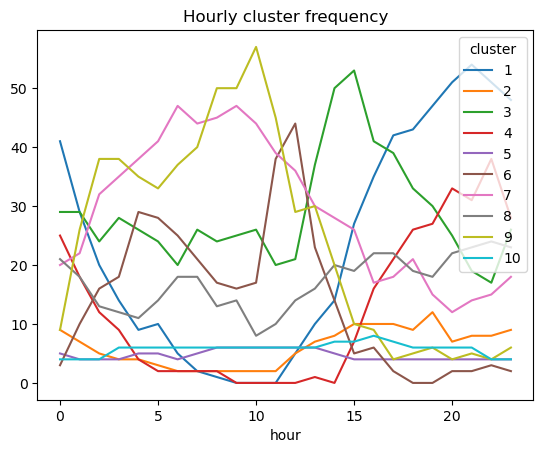

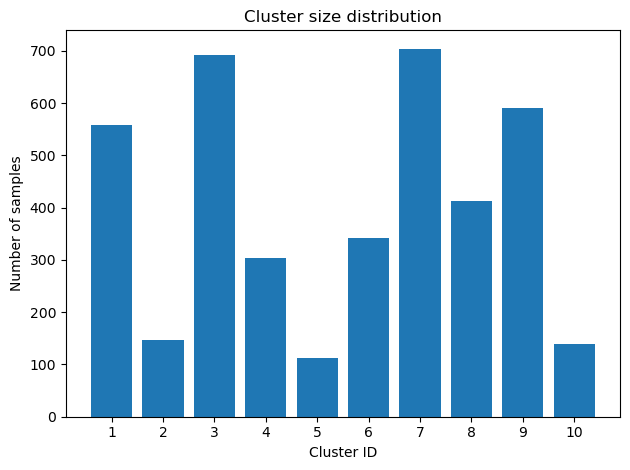

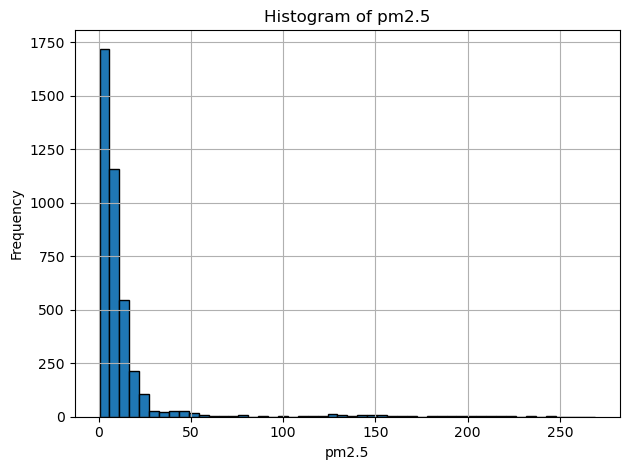

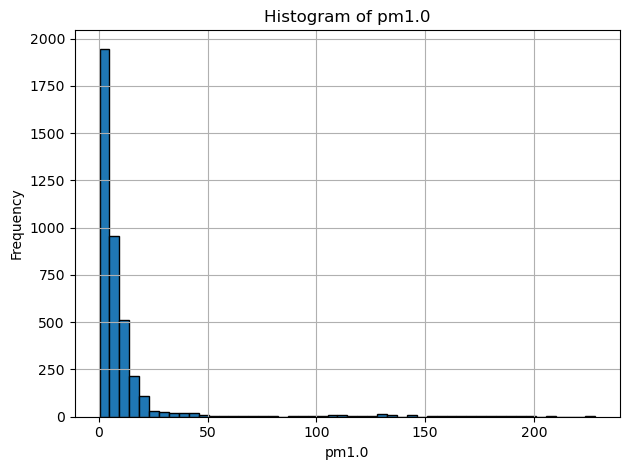

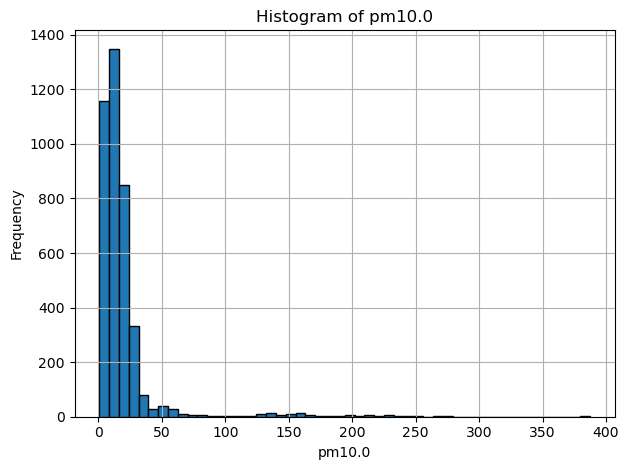

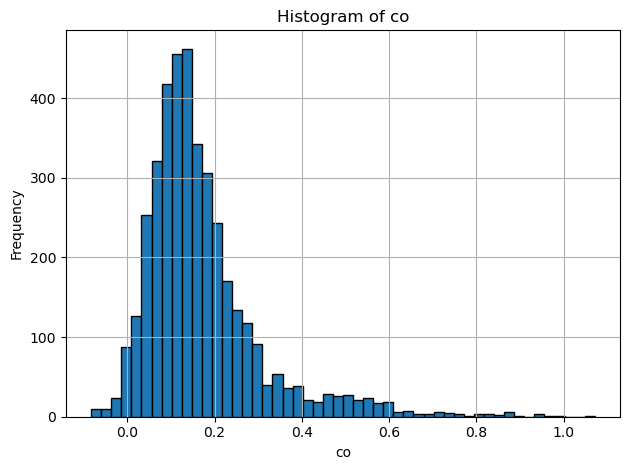

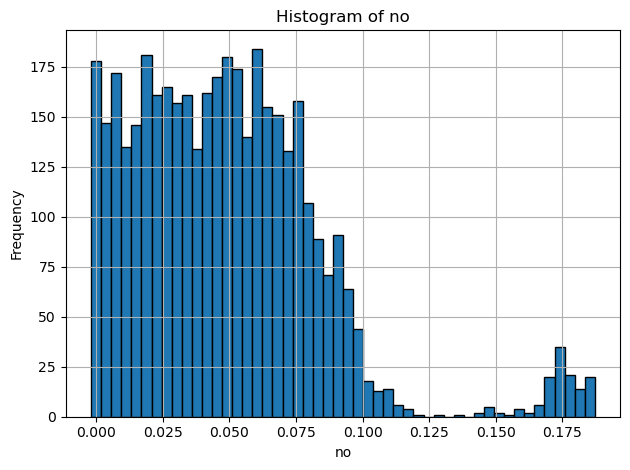

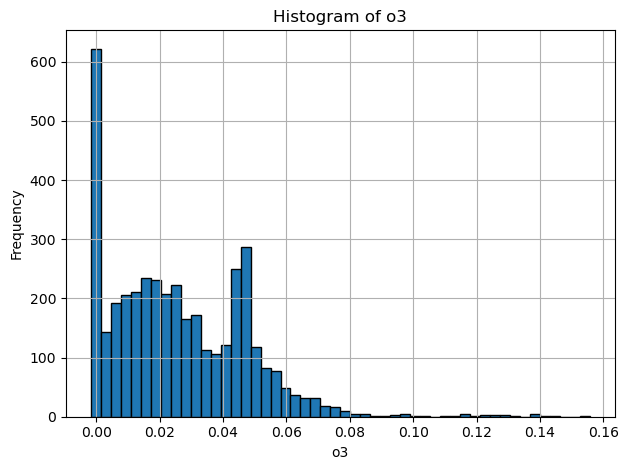

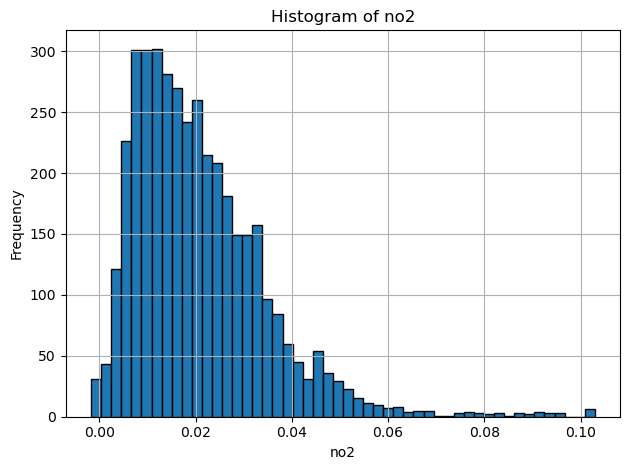

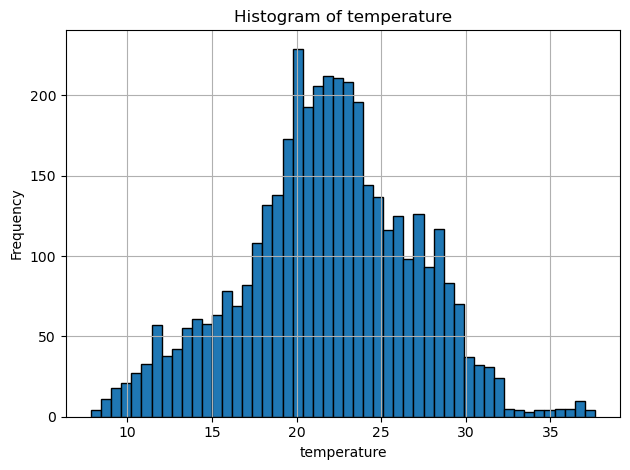

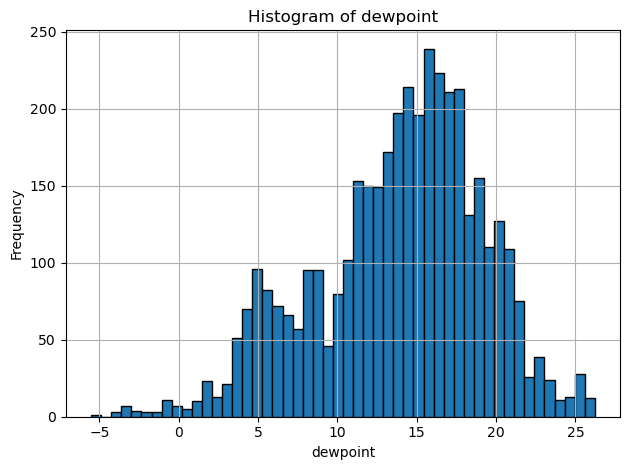

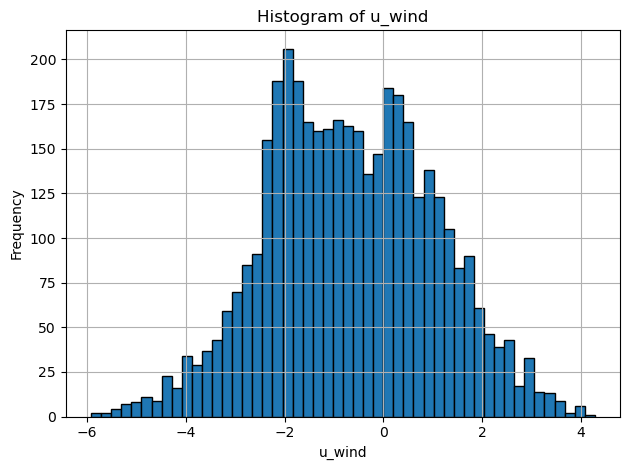

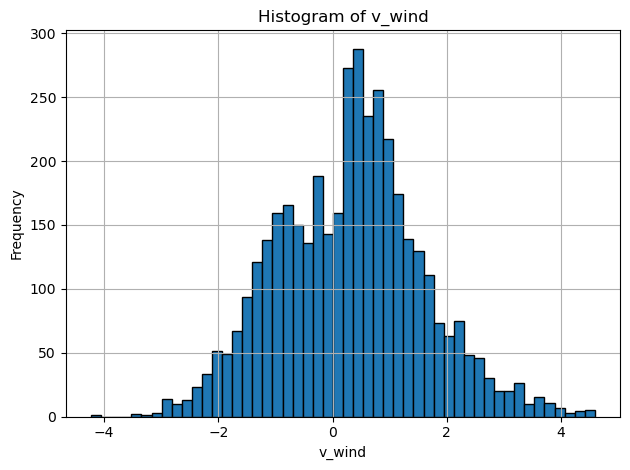

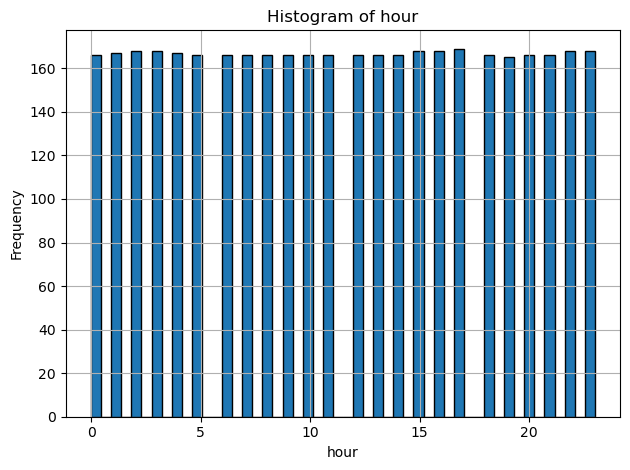

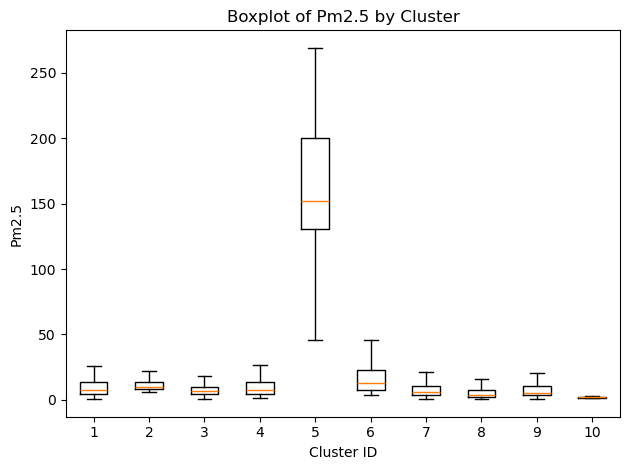

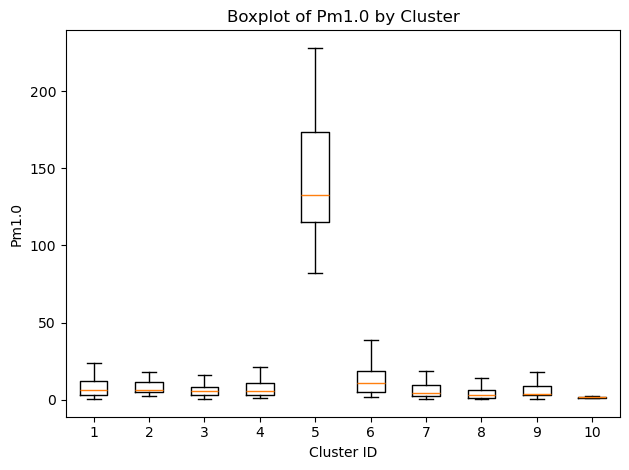

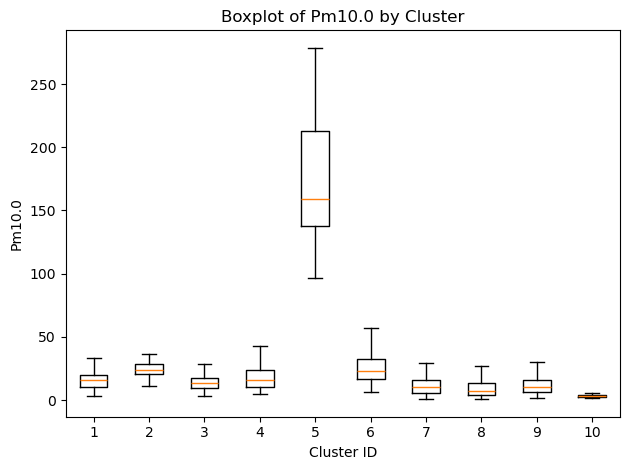

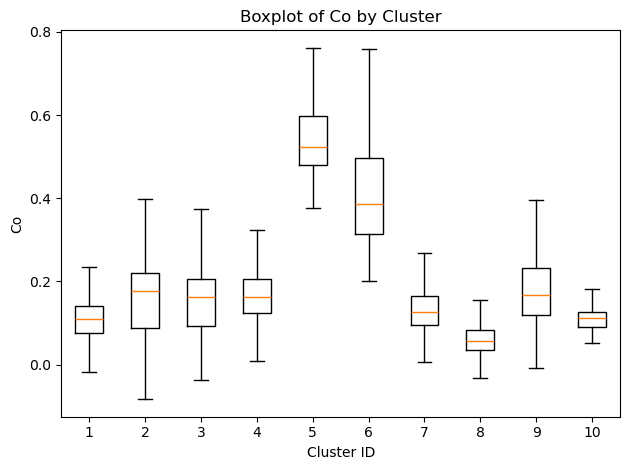

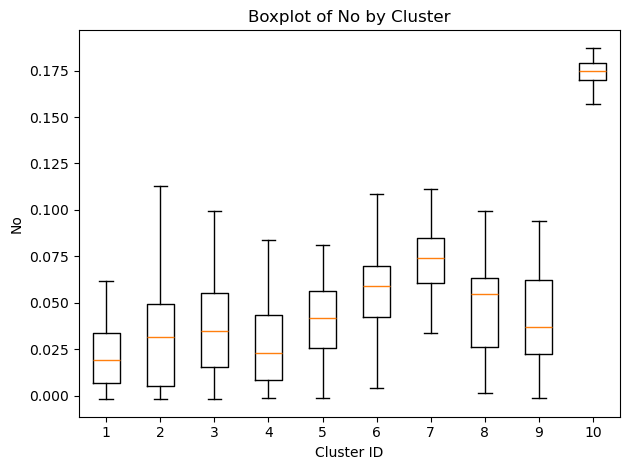

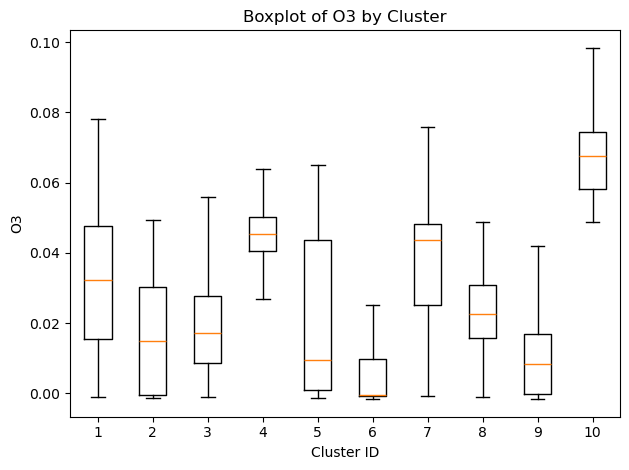

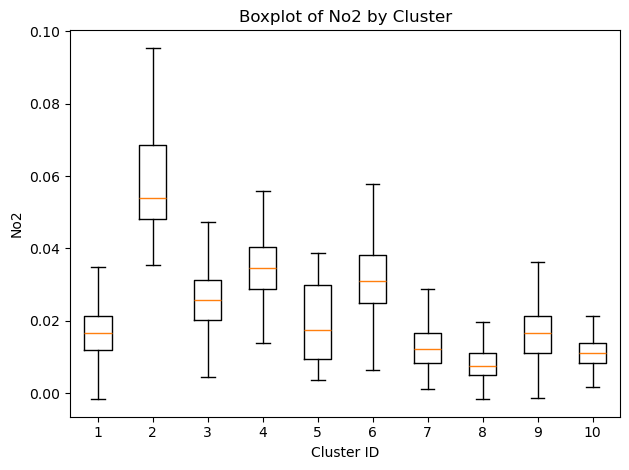

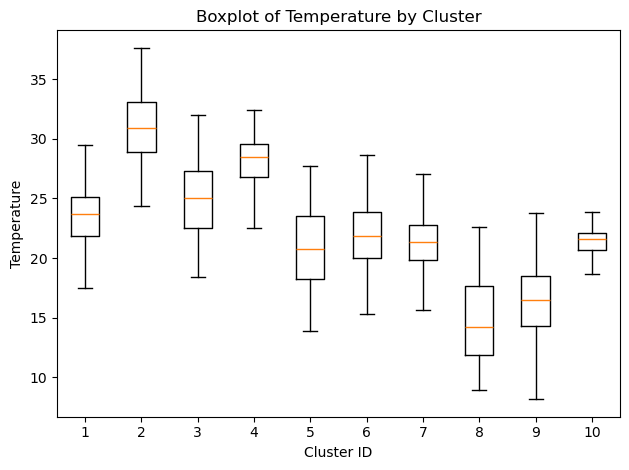

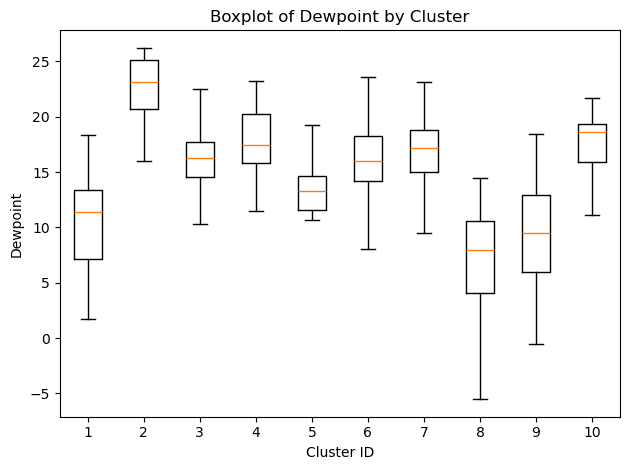

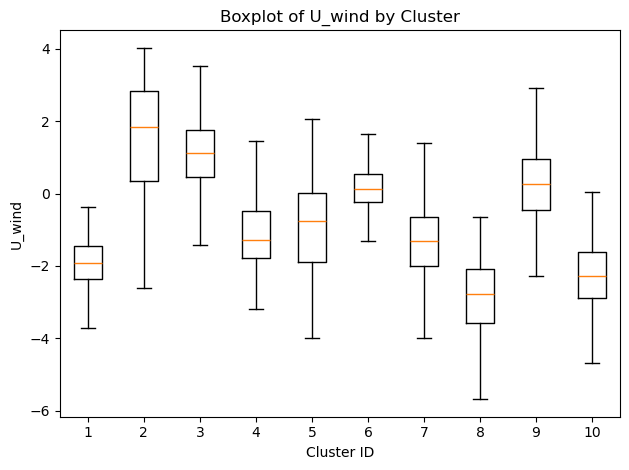

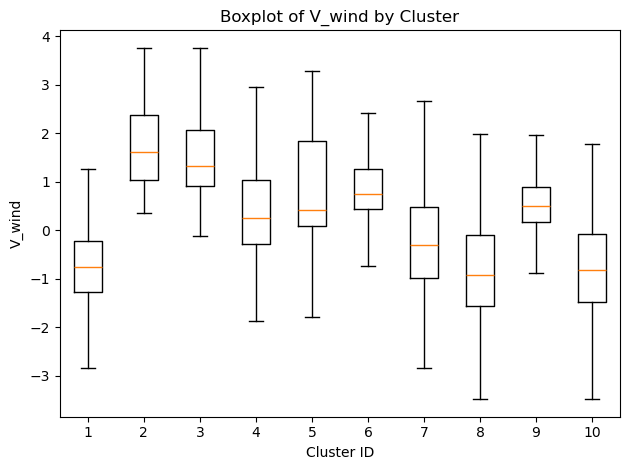

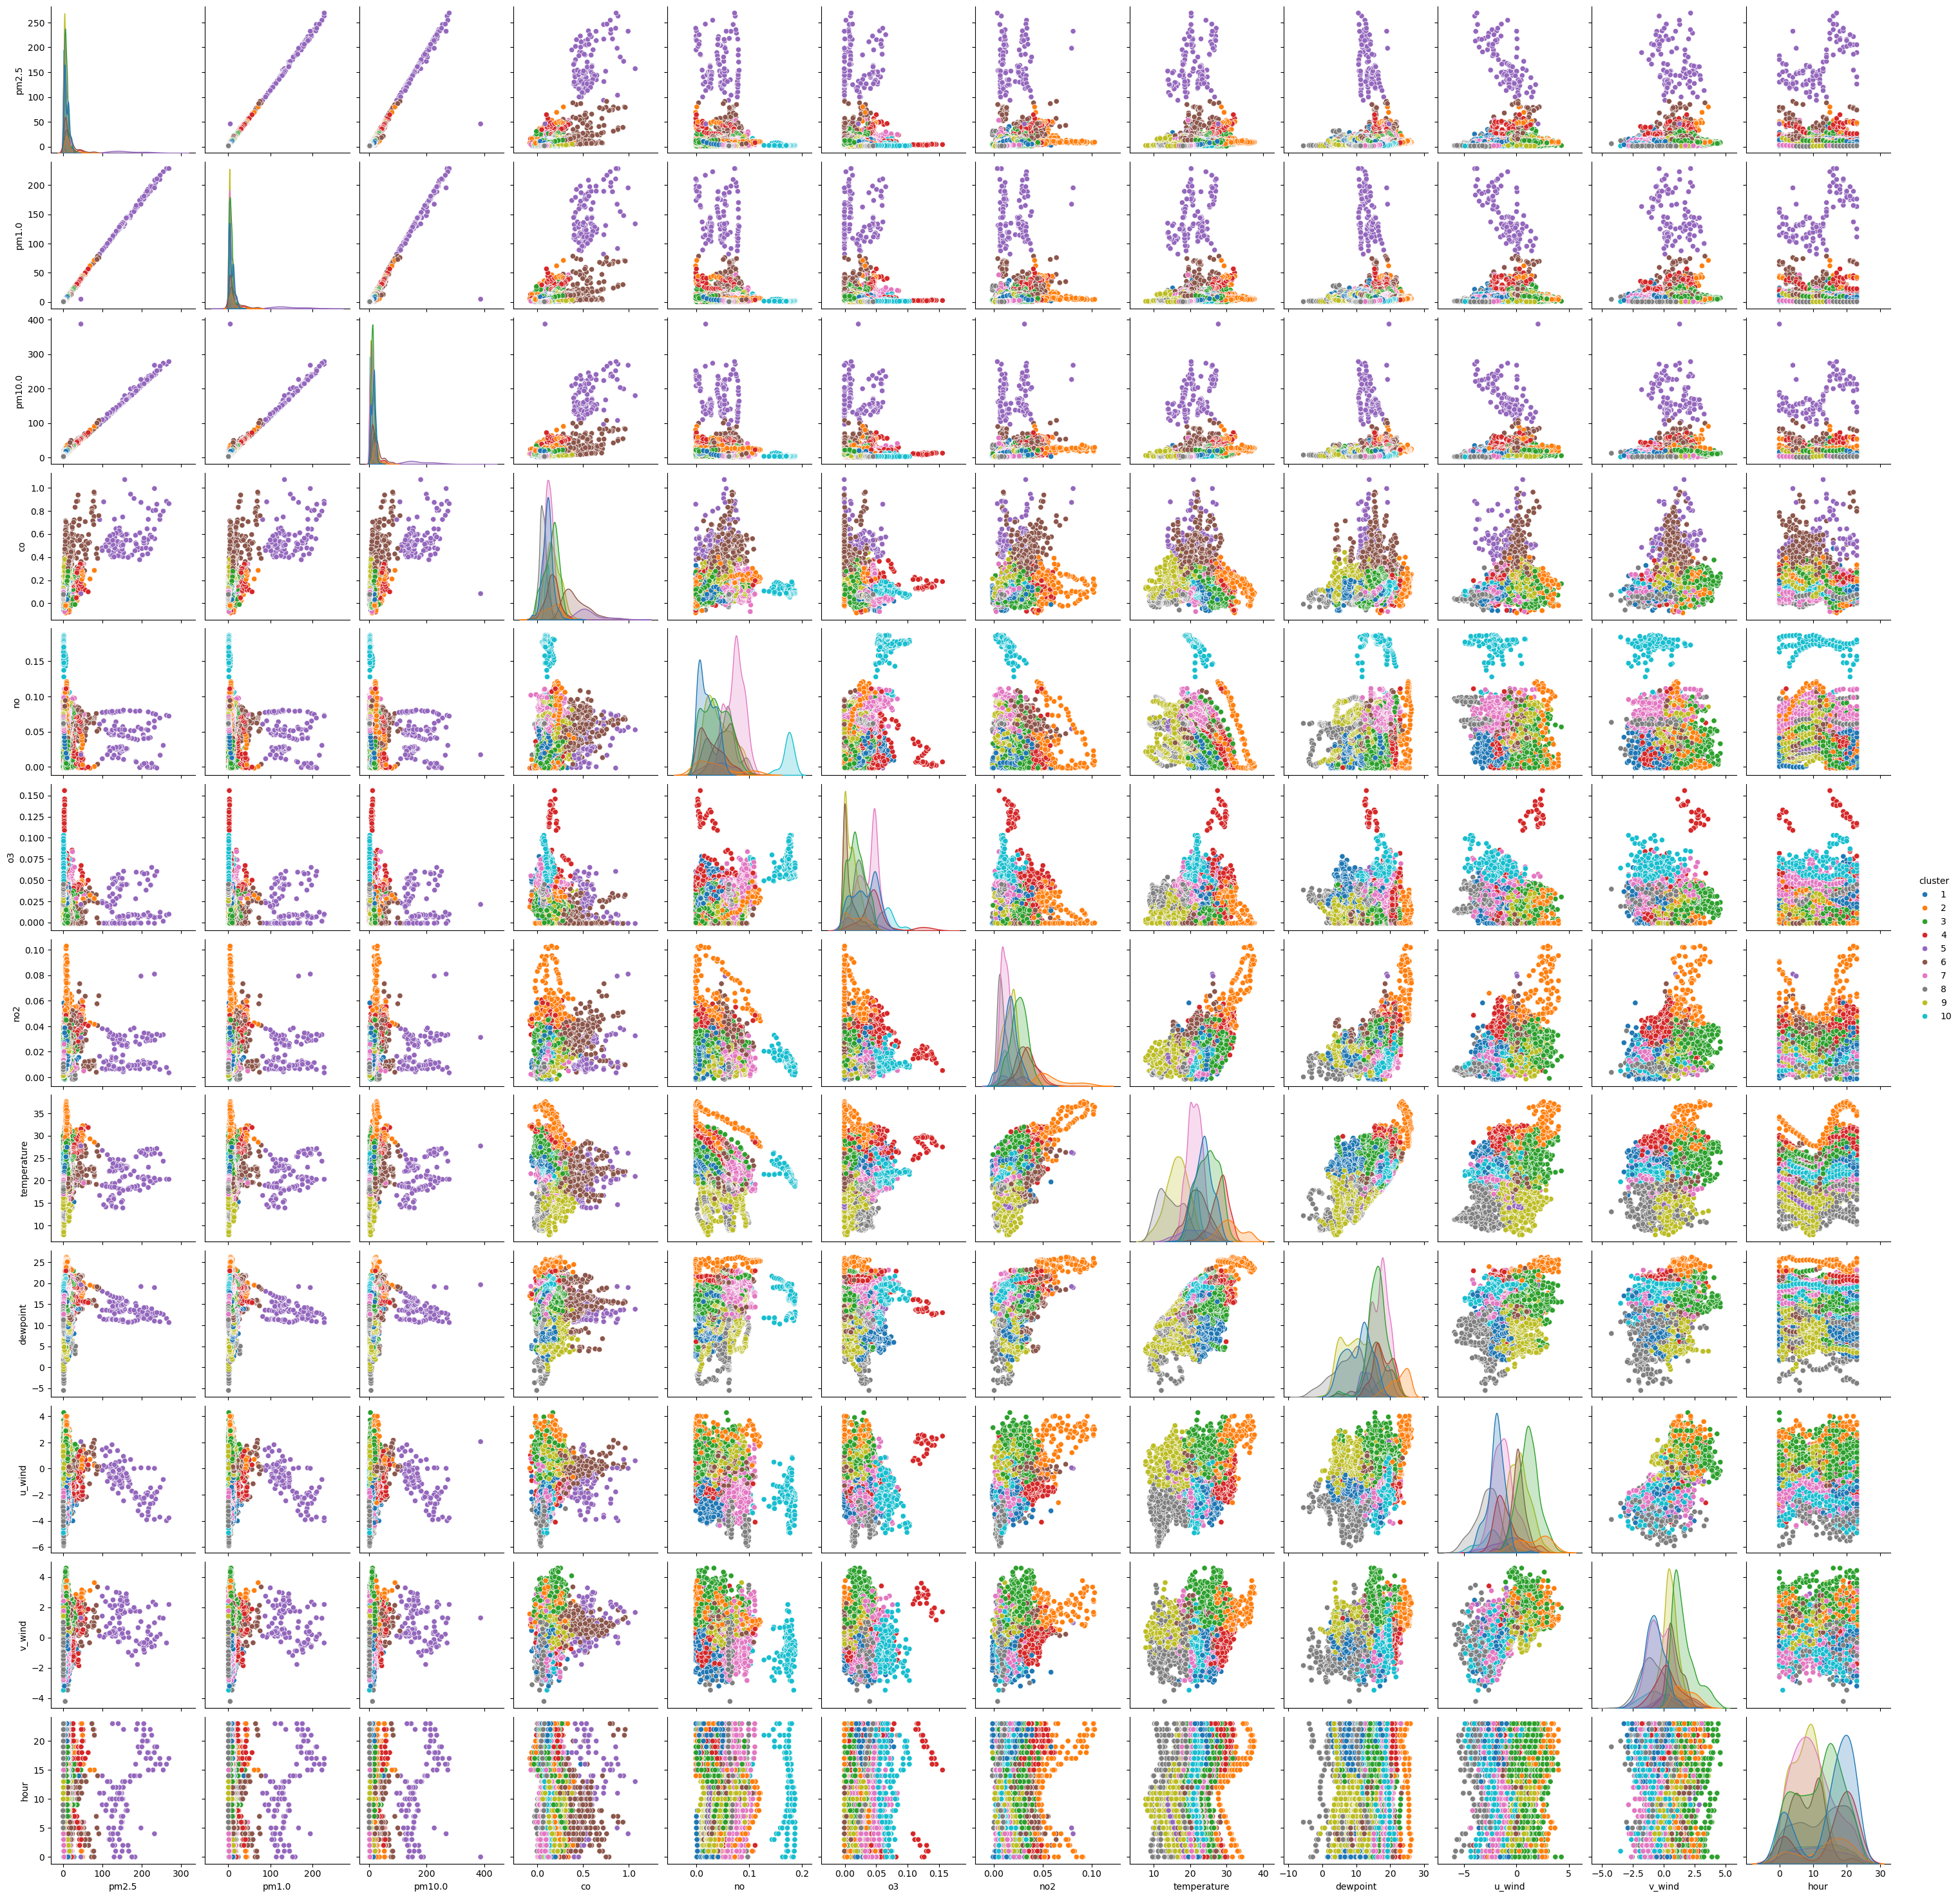

In [70]:
import numpy as np
import pandas as pd
import xarray as xr
from sklearn.preprocessing import StandardScaler
from sklearn.cluster      import KMeans
import matplotlib.pyplot as plt

def load_and_clean_with_time(ds_path, variables, time_dim='time'):
    ds = xr.open_dataset(ds_path, engine='netcdf4')
    arrays = [ds[v].to_numpy().ravel() for v in variables]
    times  = ds[time_dim].to_numpy().ravel()
    mask   = np.all([~np.isnan(a) for a in arrays], axis=0)
    data   = np.column_stack([a[mask] for a in arrays])
    times  = times[mask]
    df = pd.DataFrame(data, columns=variables)
    df['time'] = pd.to_datetime(times)
    return df

def cluster_and_attach(df, variables, n_clusters=10):
    # 1) Isolate just the numeric feature matrix
    X = df[variables].values
    
    # 2) standardize
    scaler = StandardScaler()
    X_norm = scaler.fit_transform(X)
    
    # 3) run k-means
    km = KMeans(n_clusters=n_clusters, random_state=42)
    labels0 = km.fit_predict(X_norm)
    
    # 4) attach labels (shifted to 1–10) back onto the original df
    df['cluster'] = labels0 + 1
    return df

def plot_cluster_histogram(df):
    counts = df['cluster'].value_counts().sort_index()
    plt.figure()
    plt.bar(counts.index, counts.values)
    plt.xlabel('Cluster ID')
    plt.ylabel('Number of samples')
    plt.title('Cluster size distribution')
    plt.xticks(range(1, 11))
    plt.tight_layout()
    plt.show()

def plot_all_variable_histograms(df):
    for var in df.columns:
        if var == 'cluster':
            continue
        plt.figure()
        df[var].hist(bins=50, edgecolor='black')
        plt.title(f'Histogram of {var}')
        plt.xlabel(var)
        plt.ylabel('Frequency')
        plt.tight_layout()
        plt.show()

def plot_variable_pairs(df):
    sns.pairplot(df, hue='cluster', hue_order=range(1, 11), palette='tab10', corner=False)
    plt.show()

def plot_box_time(df, vars_list):
    df['hour'] = df.index.hour
    
    clusters = sorted(df['cluster'].unique())

    for var in vars_list:
        if var == 'cluster':
            continue   
        data = [df.loc[df['cluster'] == c, var].values for c in clusters]

        plt.figure()
        plt.boxplot(data, tick_labels=clusters, showfliers=False)
        plt.xlabel('Cluster ID')
        plt.ylabel(var.capitalize())
        plt.title(f'Boxplot of {var.capitalize()} by Cluster')
        plt.tight_layout()
        plt.show()

def main():
    vars_list = ['pm2.5','pm1.0','pm10.0','co','no','o3','no2','temperature','dewpoint','u_wind','v_wind']
    df = load_and_clean_with_time('D://Data//crocus_neiu_a1_and_filtered_30min.nc', vars_list)
    
    # pass in the list of numeric columns ONLY
    df = cluster_and_attach(df, vars_list, n_clusters=10)
    
    df['time'] = pd.to_datetime(df['time'])
    df.set_index('time', inplace=True)
    df['hour'] = df.index.hour
    
    print(df.head(10))                      # to check first 10 rows
    print(df['cluster'].value_counts().sort_index())
    hourly = df.groupby(['hour','cluster']).size().unstack(fill_value=0)
    hourly.plot(title='Hourly cluster frequency')
    plt.show()

    # function calls
    plot_cluster_histogram(df)
    plot_all_variable_histograms(df)
    plot_box_time(df, vars_list)
    plot_variable_pairs(df)
    
if __name__ == '__main__':
    main()
